In [40]:
import numpy as np
from scipy.integrate import odeint
import scipy.stats
import matplotlib.pyplot as plt
import copy

In [41]:
# Import functions directly from github
# Important: note that we use raw.githubusercontent.com, not github.com

import requests
url = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/plot_utility.py'
r = requests.get(url)

# Store the file to the colab working directory
with open('plot_utility.py', 'w') as f:
    f.write(r.text)

# import the function we want from that file
from plot_utility import plot_tme

# Nominal trajectory, measurements

In [42]:
class MonoCamera:
    def __init__(self):
        self.std = 0.1
        self.v = scipy.stats.norm(0, self.std)
        
    def control(self, X, t):
        #g_des = (np.sin(0.05*t)+1)**4*np.sin(0.5*t)
        #g_des = np.sin(2*t)
        #g, d = X 
        #gain = 0.5
        # u_g = 4*np.sin(2*t) #gain*(g_des-g)
        u_g = np.piecewise(t,
                   [t < 2, (t >= 2) & (t < 8), t >= 8],
                   [0,
                    lambda t: 8*np.sin(10*t),
                    0])
        return u_g
    
    def f(self, X, t):
        g, d = X
        # control
        u_g = self.control(X, t)
        # dynamics
        g_dot = u_g # - 0.01*g
        d_dot = 0
        x_dot = [g_dot, d_dot]
        return x_dot
    
    # g = ground speed
    # d = distance
    def h(self, X, t):
        g, d = X
        u_g = self.control(X, t)
        # define all the sensors I want in the system to use for simulation
        # g = ground speed
        # d = distance
        y = np.array([g/d + self.v.rvs(g.shape), 
                      g + self.v.rvs(g.shape), 
                      d + self.v.rvs(d.shape),
                      3*g + self.v.rvs(g.shape)])
        return y
    
    def simulate(self, x0, tsim):
        result = odeint(self.f, x0, tsim)
        X = result.T
        U = np.atleast_2d(self.control(X, tsim))
        Y = self.h(X, tsim)
        return X, U, Y

In [43]:
sys = MonoCamera()

x0 = np.array([5, 3]) # initial conditions
tsim = np.arange(0, 10, 0.01) # simulation  time

X, U, Y = sys.simulate(x0, tsim)

(0.0, 10.0)

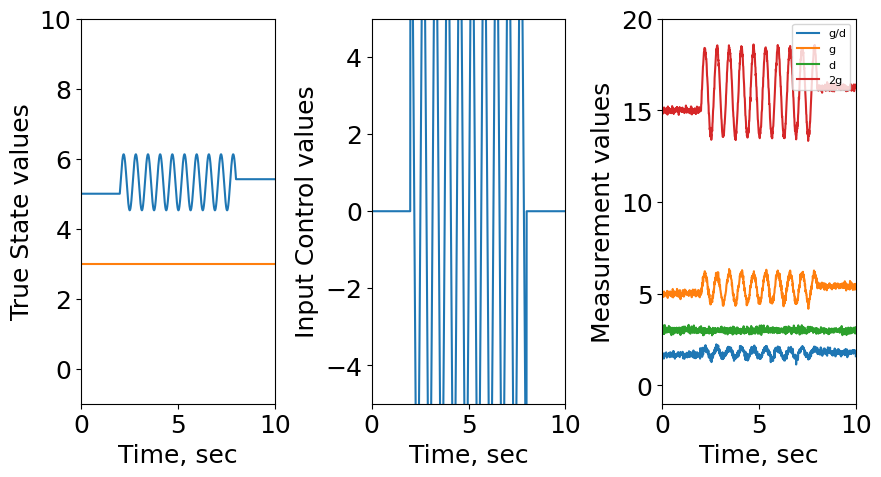

In [44]:
fig = plt.figure(figsize=(10,5))
fig.subplots_adjust(wspace=0.5)

# States
ax = fig.add_subplot(131)

ax.plot(tsim, X[0,:])
ax.plot(tsim, X[1,:])

ax.set_xlabel('Time, sec')
ax.set_ylabel('True State values')

ax.set_ylim([-1, 10])
ax.set_xlim([0, 10])

# Controls
ax = fig.add_subplot(132)

ax.plot(tsim, U[0,:])

ax.set_xlabel('Time, sec')
ax.set_ylabel('Input Control values')

ax.set_ylim([-5, 5])
ax.set_xlim([0, 10])

# Measurements
ax = fig.add_subplot(133)

ax.plot(tsim, Y[0,:], label='g/d')
ax.plot(tsim, Y[1,:], label='g')
ax.plot(tsim, Y[2,:], label='d')
ax.plot(tsim, Y[3,:], label='2g')
#ax.plot(tsim, Y[1,:])

# legend on the right
ax.legend(loc='upper right', fontsize=8)

ax.set_xlabel('Time, sec')
ax.set_ylabel('Measurement values')
ax.set_ylim([-1, 20])
ax.set_xlim([0, 10])

# Extended Kalman Filter

Note: this EKF function expects everything to be given as 2D arrays. 

## Initial conditions
Set up the initial conditions for the EKF. 

In [45]:
# Initial conditions
x0 = np.array([[5], [2.5]])
P0 = 1000000*np.eye(2)

# Noise defined by measurement noise
R = sys.std**2*np.eye(len(Y))
print(R.shape)

# Fairly accurate model
Q = 5e-4*np.eye(2)

(4, 4)


In [46]:
#!pip install git+https://github.com/florisvb/pyEKF.git

In [47]:
import ekf

In [48]:
def f_d(X, U):
    dt=0.01
    g, d = np.ravel(X)
    u, = np.ravel(U)
    g_dot = u # 0.01*g
    d_dot = 0
    x_new = np.atleast_2d(np.array([g + g_dot*dt, d + d_dot*dt])).T
    return x_new

def h_d(X, U):
    dt=0.01
    g, d = np.ravel(X)
    u, = np.ravel(U)
    # define the sensors that I will be giving the EKF
    sensors = [np.array( [g/d] ), np.array(g), np.array(d), np.array(2*g)]
    y = np.atleast_2d(np.hstack(sensors)).T
    return y

Use a modified R matrix to determine which combinations of sensors will be used by the EKF. Really large element of R means that the EKF will essentially ignore that sensor. According to Austin at least...

In [49]:
import itertools

def get_all_R(R_original):
    numbers = []
    for i in range(len(R)):
        numbers.append(i)

    all_combinations = []

    # Generate combinations
    for r in range(1, len(numbers) + 1):
        combs = list(itertools.combinations(numbers, r))
        all_combinations.extend(combs)

    R_modified = []

    for r in range(1, 5):
        for combo in itertools.combinations(range(4), r):
            matrix = R_original.copy()
            
            # Set large number for diagonals NOT in the combo
            for i in range(4):
                if i not in combo:
                    matrix[i, i] = 1e20
            
            R_modified.append(matrix)
    return R_modified

R_modified = get_all_R(R)

In [50]:
import pandas as pd

results = [pd.DataFrame(columns = ['x0_hat', 'x1_hat', 'P0', 'P1', 's0', 's1', 'invJk_x0', 'invJk_x1', '3sigma_x0', '3sigma_x1']) for _ in range(len(R_modified))]

for i in range(len(R_modified)):
    R = R_modified[i]
    # run the EKF

    xhat, P, s = ekf.ekf(Y, x0, f_d, h_d, Q, R, U)
    results[i]['x0_hat'] = xhat[0, :]
    results[i]['x1_hat'] = xhat[1, :]
    results[i]['P0'] = P[0, 0, :]
    results[i]['P1'] = P[1, 1, :]
    results[i]['s0'] = s[0, :]
    results[i]['s1'] = s[1, :]

In [51]:
# print(results[0])

## Plot Results
Plot the results of the EKF without considering the 3 sigma bounds. 

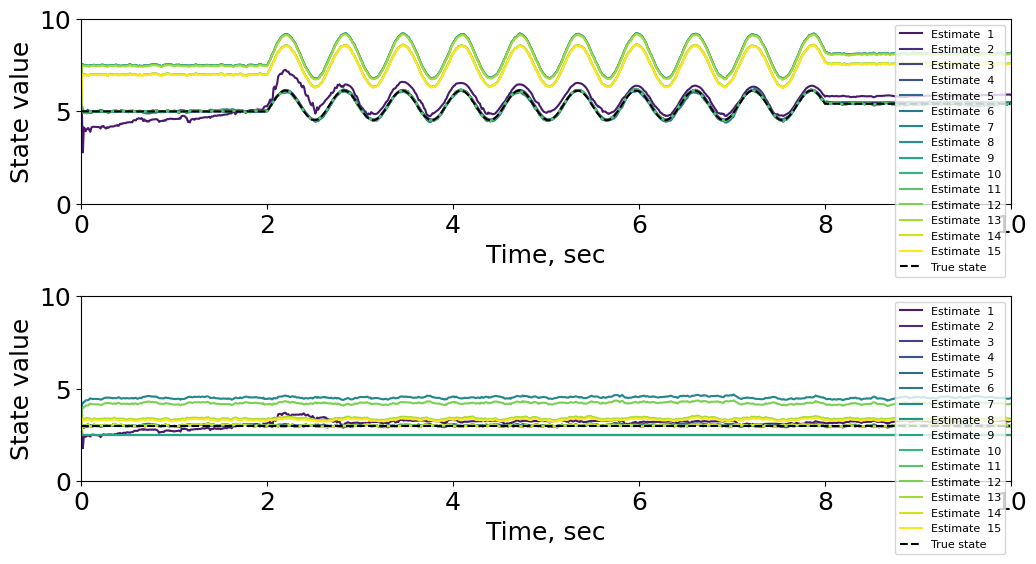

In [52]:
def kf_plot(num_plots, data, allR, time, states):
    fig, axs = plt.subplots(len(num_plots), 1, figsize=(12, 6))
    fig.subplots_adjust(hspace=0.5)
    cmap = plt.get_cmap('viridis', len(allR)+1)
    for j in range(len(num_plots)):
        for i in range(len(allR)):
            axs[j].plot(time, data[i][states[j]], label=f'Estimate  {i+1}', color=cmap(i+1))
        axs[j].set_xlabel('Time, sec')
        axs[j].set_ylabel('State value')
        axs[j].set_ylim([0, 10])
        axs[j].set_xlim([0, 10])
        axs[j].plot(time, X[j, :], label='True state', linestyle='--', color='black')
        axs[j].legend(loc='upper right', fontsize=8)
    plt.show()

kf_plot([0, 1], results, R_modified, tsim, ['x0_hat', 'x1_hat'])


# Cramer Rao Bound

### numerical jacobian

Maybe could be more efficient using ``jax``?

In [53]:
def jacobian(f, x0, u0, epsilon=0.001):
    
    # Get A
    Aj = []
    for i in range(len(f(x0,u0))):
        
        def f_scalar(x,u,i):
            x_new = f(x, u)
            return np.ravel(x_new)[i]
        
        j = scipy.optimize.approx_fprime(x0, f_scalar, epsilon, u0, i)
        Aj.append(j)
        
    # Get B
    Bj = []
    for i in range(len(f(x0,u0))):
        
        def f_scalar(u,x,i):
            x_new = f(x, u)
            return np.ravel(x_new)[i]
        
        j = scipy.optimize.approx_fprime(u0, f_scalar, epsilon, x0, i)
        Bj.append(j)
    
    return np.matrix(np.vstack(Aj)), np.matrix(np.vstack(Bj))

### cramer rao bound

In [54]:
inv = np.linalg.inv

def compute_invJk_diags(data, allR, time):
    for i in range(len(allR)):
        Jk = inv(P0)
        Ri = allR[i]

        for j in range(len(time)):
            xhat_j = np.array([data[i]['x0_hat'][j], data[i]['x1_hat'][j]])
            u_j = U[:,j]

            A, B = jacobian(f_d, np.ravel(xhat_j), np.ravel(u_j))
            C, D = jacobian(h_d, np.ravel(xhat_j), np.ravel(u_j))

            Jk = inv(Q) - inv(Q)@A@inv(Jk + A.T@inv(Q)@A)@A.T@inv(Q) + C.T@inv(Ri)@C

            lamb = 1e-5
            Jk = Jk + lamb*np.eye(np.shape(Jk)[0])
            invJk = inv(Jk)

            data[i].at[j, 'invJk_x0'] = np.diag(invJk)[0]
            data[i].at[j, 'invJk_x1'] = np.diag(invJk)[1]       

compute_invJk_diags(results, R_modified, tsim)

In [55]:
def compute_3sigma(data, allR, time):
    for i in range(len(allR)):
        for j in range(len(time)):
            three_sigma_x0 = 3 * np.sqrt(data[i]['invJk_x0'][j])
            three_sigma_x1 = 3 * np.sqrt(data[i]['invJk_x1'][j])
            data[i].at[j, '3sigma_x0'] = three_sigma_x0
            data[i].at[j, '3sigma_x1'] = three_sigma_x1

compute_3sigma(results, R_modified, tsim)


### show CRB

Red dashed lines are 3-sigma bounds determined by the KF.
Gray shading is the 3-sigma CRB bound. 

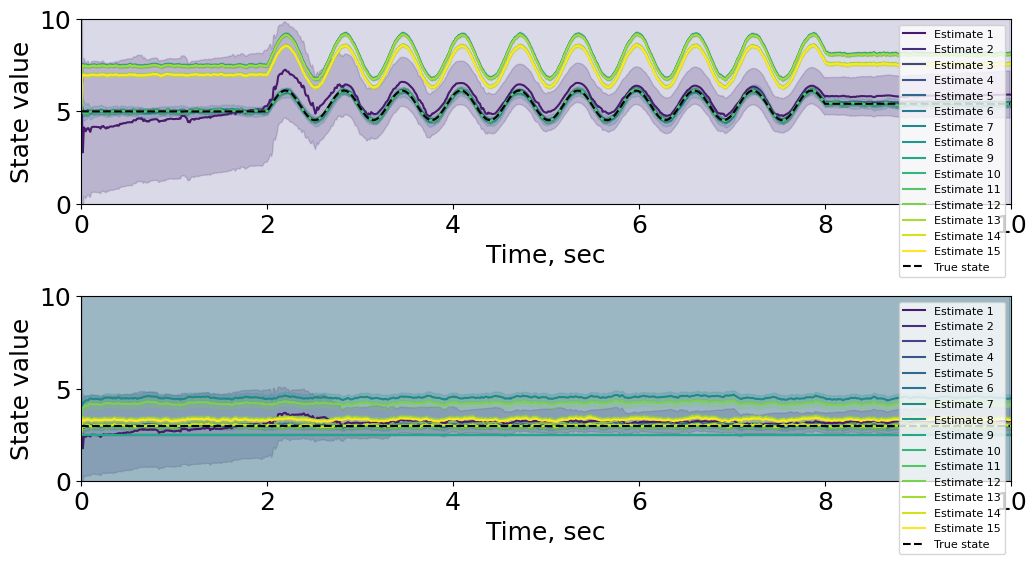

In [58]:
def threesigma_plot(num_plots, data, allR, time, states, sigmas):
    fig, axs = plt.subplots(len(num_plots), 1, figsize=(12, 6))
    fig.subplots_adjust(hspace=0.5)
    cmap = plt.get_cmap('viridis', len(allR)+1)
    for j in range(len(num_plots)):
        for i in range(len(allR)):
            state_array = np.asarray(data[i][states[j]], dtype=float)
            sigma_array = np.asarray(data[i][sigmas[j]], dtype=float)

            axs[j].plot(time, state_array, label=f'Estimate {i+1}', color=cmap(i+1))
            axs[j].fill_between(time, state_array - sigma_array, state_array + sigma_array, 
                                alpha=0.2, color=cmap(i+1))

        axs[j].set_xlabel('Time, sec')
        axs[j].set_ylabel('State value')
        axs[j].set_ylim([0, 10])
        axs[j].set_xlim([0, 10])
        axs[j].plot(time, X[j, :], label='True state', linestyle='--', color='black')
        axs[j].legend(loc='upper right', fontsize=8)
    plt.show()

threesigma_plot([0, 1], results, R_modified, tsim, ['x0_hat', 'x1_hat'], ['3sigma_x0', '3sigma_x1'])

# Sorting out based on error

In [59]:
# for every position and velocity, if invJk is bigger than 1, then we want to disregard the data
# we will use invJk to determine if the data is trustworthy or not
def find_trustworthy(data, allR, state_invJk):
    trustworthy=[]
    for i in range(len(allR)):
        if np.mean(data[i][state_invJk]) < 100:
            trustworthy.append(i)
    return trustworthy

trustworthy_x0 = find_trustworthy(results, R_modified, 'invJk_x0')
trustworthy_x1 = find_trustworthy(results, R_modified, 'invJk_x1')

print('valid combos x0: ', len(trustworthy_x0))
print(trustworthy_x0)
print('valid combos x1: ', len(trustworthy_x1))
print(trustworthy_x1)
    

valid combos x0:  14
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
valid combos x1:  12
[0, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14]


## Re-plot only the trustworthy measurements

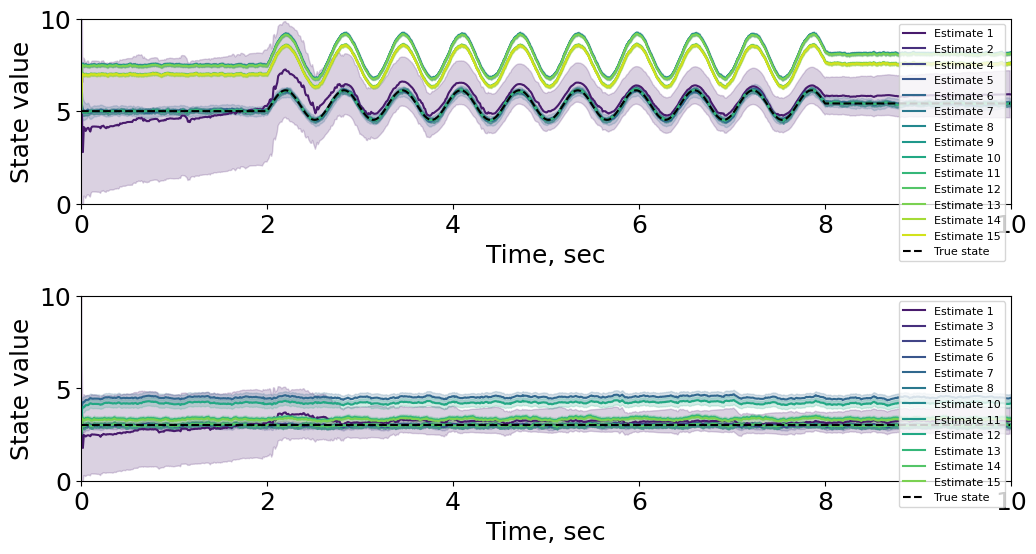

In [62]:
# # Same plot as before, just only for the trustworthy data
def trustworthy_plot(num_plots, data, allR, trustworthy_indices, time, states, sigmas):
    fig, axs = plt.subplots(num_plots, 1, figsize=(12, 6))
    if num_plots == 1:
        axs = [axs]
    fig.subplots_adjust(hspace=0.5)
    cmap = plt.get_cmap('viridis', len(allR)+1)
    for i in range(num_plots):
        indices = trustworthy_indices[i]
        for j in range(len(indices)):
            state_array = np.asarray(data[indices[j]][states[i]], dtype=float)
            sigma_array = np.asarray(data[indices[j]][sigmas[i]], dtype=float)
            axs[i].plot(time, state_array, label=f'Estimate {indices[j]+1}', color=cmap(j+1))
            axs[i].fill_between(time, state_array - sigma_array, state_array + sigma_array,
                                alpha=0.2, color=cmap(j+1))
        axs[i].set_xlabel('Time, sec')
        axs[i].set_ylabel('State value')
        axs[i].set_ylim([0, 10])
        axs[i].set_xlim([0, 10])
        axs[i].plot(time, X[i, :], label='True state', linestyle='--', color='black')
        axs[i].legend(loc='upper right', fontsize=8)
    plt.show()


trustworthy = [trustworthy_x0, trustworthy_x1]
trustworthy_plot(2, results, R_modified, trustworthy, tsim, ['x0_hat', 'x1_hat'], ['3sigma_x0', '3sigma_x1'])


# Most Observable Section

In [71]:
# compute the average of the 3 sigma bounds for the trustowrthy data of both states\     
def find_trustworthy_windows(data, state, sigma, trustworthy_indices, threshold):
    time = 10
    window_size = 1
    step = 0.01
    samples_per_window = int(window_size/step)
    start = None
    windows = []
    for i in range(int(time/window_size)):
        windows.append([i*window_size, (i+1)*window_size])
    trustworthy_windows = []

    for i in range(len(windows)):
        this_window = windows[i]
        window_3sigma_avg = []
        for j in range(len(trustworthy_indices)):
            window_3sigma_avg.append(np.mean(data[trustworthy_indices[j]][sigma][int(this_window[0]*100):int(this_window[1]*100)]))
        avg = np.mean(window_3sigma_avg)
        if avg < threshold:
            trustworthy_windows.append(windows[i])
        else:
            continue
    return trustworthy_windows

trustworthy_windows_x0 = find_trustworthy_windows(results, 'x0_hat', '3sigma_x0', trustworthy_x0, 0.2)
trustworthy_windows_x1 = find_trustworthy_windows(results, 'x1_hat', '3sigma_x1', trustworthy_x1, 0.2)
print(trustworthy_windows_x0)
print(trustworthy_windows_x1)


[[3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10]]
[[4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10]]


Now, plot only the data from the trustworthy windows.

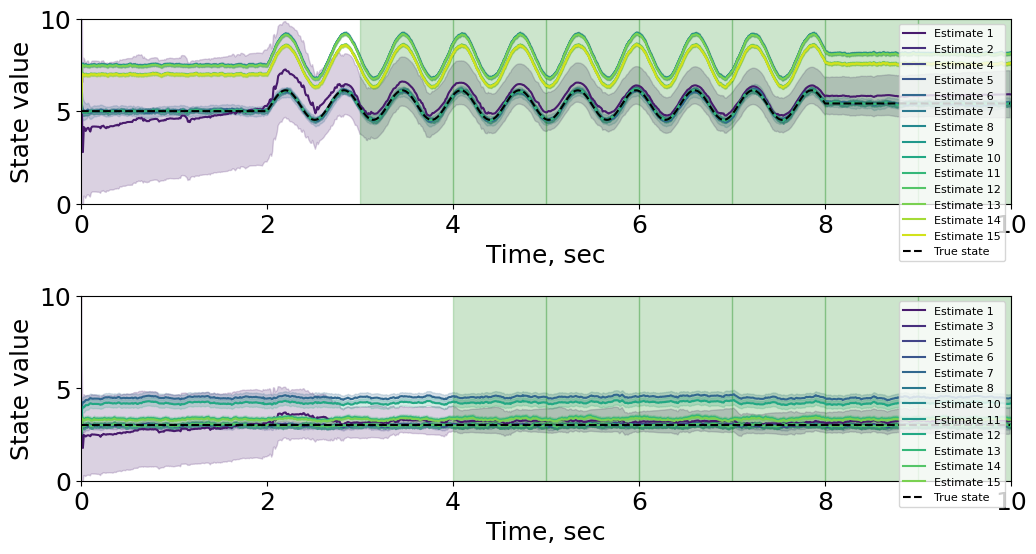

In [72]:
def trustworthy_plot(num_plots, data, allR, trustworthy_indices, time, states, sigmas, highlighted_windows):
    fig, axs = plt.subplots(num_plots, 1, figsize=(12, 6))
    fig.subplots_adjust(hspace=0.5)
    cmap = plt.get_cmap('viridis', len(allR)+1)
    
    for i in range(num_plots):
        indices = trustworthy_indices[i]
        for j in range(len(indices)):
            state_array = np.asarray(data[indices[j]][states[i]], dtype=float)
            sigma_array = np.asarray(data[indices[j]][sigmas[i]], dtype=float)
            axs[i].plot(time, state_array, label=f'Estimate {indices[j]+1}', color=cmap(j+1))
            axs[i].fill_between(time, state_array - sigma_array, state_array + sigma_array,
                                alpha=0.2, color=cmap(j+1))
        axs[i].set_xlabel('Time, sec')
        axs[i].set_ylabel('State value')
        axs[i].set_ylim([0, 10])
        axs[i].set_xlim([0, 10])
        axs[i].plot(time, X[i, :], label='True state', linestyle='--', color='black')
        axs[i].legend(loc='upper right', fontsize=8)
    # highlight the trsutworthy windows with green
    for i in range(len(highlighted_windows)):
        for j in range(len(highlighted_windows[i])):
            axs[i].axvspan(highlighted_windows[i][j][0], highlighted_windows[i][j][1], color='green', alpha=0.2)
    plt.show()

trustworthy = [trustworthy_x0, trustworthy_x1]
windows = [trustworthy_windows_x0, trustworthy_windows_x1]
trustworthy_plot(2, results, R_modified, trustworthy, tsim, ['x0_hat', 'x1_hat'], ['3sigma_x0', '3sigma_x1'], windows)


# Agreement Heatmap
Now, put all the trustworthy measurements into a heatmap to how they agree. Here are the required functions:

In [ ]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

def get_time(trustworthy_windows):
    window_size = 1
    step = 0.01
    samples_per_window = int(window_size/step)
    time_indices = []
    for i in range(len(trustworthy_windows)):
        time_indices.append([int(trustworthy_windows[i][0]*samples_per_window), int(trustworthy_windows[i][1]* samples_per_window)])
    start = time_indices[0][0]
    end = time_indices[-1][1]
    return start, end

def make_adj_matrix(data, trustworthy_indices, state, time_start, time_end, three_sigma):
    adj_matrix = np.ones((len(trustworthy_indices), len(trustworthy_indices)))
    for i in range(len(trustworthy_indices)):
        for j in range(len(trustworthy_indices)):
            if i == j: continue
            else:
                data_i = np.array(data[i][state][time_start:time_end])
                data_j = np.array(data[j][state][time_start:time_end])
                sigma_i = np.array(data[i][three_sigma][time_start:time_end])
                sigma_j = np.array(data[j][three_sigma][time_start:time_end])
    return adj_matrix

# function to plot the adjacency matrix
def plot_adjacency_matrix(matrix, indices, title):
    # Create a custom colormap
    colors =["red", "blue"]
    cmap = "custom colormap"
    custom_cmap = LinearSegmentedColormap.from_list(cmap, colors, N=100)

    # plot the adjacency matrix with the custom color map
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_title(title)
    ax.set_xlabel("How much does the data of this sensor combo...")
    ax.set_ylabel("Fall into the error range of this sensor combo?")
    sns.heatmap(matrix, cmap=custom_cmap, annot=True, fmt=".2f", cbar=False, square=True, linewidths=.5, annot_kws={"size": 5})
    ax.set_xticklabels(indices)
    ax.set_yticklabels(indices)
    # font size
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.show()


Making the adjacency matrices and plotting them.

In [97]:
x0_start, x0_end = get_time(trustworthy_windows_x0)
x1_start, x1_end = get_time(trustworthy_windows_x1)

# print(x0_start, x0_end)
# print(x1_start, x1_end)

print(np.array(results[0]['x0_hat'][x0_start:x0_end]))

adj_x0 = make_adj_matrix(results, trustworthy_x0, 'x0_hat', x0_start, x0_end, '3sigma_x0')
# print(adj_x0)



# x0_thresh = 0.15
# x1_thresh = 0.1

# adj_x0, indices_x0 = make_adjacency_matrix(trustworthy_x0, 'x0_hat', x0_start, x0_end, x0_thresh)
# adj_x1, indices_x1 = make_adjacency_matrix(trustworthy_x1, 'x1_hat', x1_start, x1_end, x1_thresh)

# print(indices_x0)
# print(len(indices_x0))
# print(adj_x0.shape)
# print()for i in range(len(trustworthy_indices)):
    #     for j in range(len(trustworthy_indices)):
    #         if i == j:
    #             continue
    #         else:
    #             R_i = trustworthy_indices[i]
    #             R_j = trustworthy_indices[j]

    #             x_i = results[R_i][state][time_start:time_end]
    #             x_j = results[R_j][state][time_start:time_end]

    #             for k in range(len(x_i)):
    #                 overlaps = []
    #                 thresh = 10 * results[R_i][three_sigma][k]

    #                 # if xj[k] is within xi[k] + or - thresh, append 1 to overlaps. else append 0
    #                 upper = x_i[k] + thresh
    #                 lower = x_j[k] - thresh

    #                 if x_j[k] in range(lower, upper):
    #                     overlaps.append(1)
    #                 else:
    #                     overlaps.append(0)
    #             percent = sum(overlaps) / len(overlaps)
    #             adj_matrix[i][j] = percent
    # return adj_matrix
# print(adj_x1.shape)

# plot_adjacency_matrix(adj_x0, indices_x0, 'Adjacency Matrix for x0')
# plot_adjacency_matrix(adj_x1, indices_x1, 'Adjacency Matrix for x1')

[5.29212448 5.27819534 5.20309965 5.16269613 5.08577731 5.00133311
 4.99302013 4.83996742 4.80652895 4.89095592 4.85749512 4.83972107
 4.96402086 4.90053182 4.89301284 4.85539019 4.8534427  4.86567313
 4.87562046 4.91171704 4.96738664 5.01817886 5.07563644 5.13103641
 5.19471498 5.24619838 5.33843222 5.41456088 5.50586523 5.54675209
 5.61274746 5.73551655 5.84500898 5.95827737 6.02579125 6.11923548
 6.21007584 6.23471337 6.25191463 6.3201414  6.4077381  6.41749701
 6.50599652 6.56791655 6.5862716  6.60111278 6.59993264 6.58864473
 6.5889883  6.56912528 6.54245523 6.5098293  6.47173988 6.41698603
 6.37369771 6.31594409 6.27510892 6.20448892 6.1351139  6.02896483
 5.97022178 5.88332547 5.75169085 5.60351317 5.61808786 5.55890579
 5.45288657 5.43342032 5.29912474 5.15966017 5.12040049 4.94159093
 4.79969353 4.79336603 4.76252854 4.74319695 4.76698525 4.8345
 4.89868822 4.88971098 4.92753827 4.96551671 5.00054393 5.0342693
 5.084549   5.1327676  5.19421356 5.2549863  5.31191283 5.3871507
 

# Sensor Identification 
Now, find the largest cliques and the sensors that are not in them.

Note that this function currently does not work properly as of May 6th. I tried to change some things to be in a function to make it more convinient and it kind of broke it. Work in progress......

In [ ]:
import networkx as nx
# write a function that can idebntify the clusters in the adjacency matrix
def clusters(matrix, indices, thresh):
    matrix = np.array(matrix)
    threshold = thresh

    # threshold matrix
    binary_matrix = (matrix > threshold).astype(int)

    # Graph
    G = nx.from_numpy_array(binary_matrix)

    # find cliques
    cliques = list(nx.find_cliques(G))

    for i in range(len(cliques)):
        this_clique = cliques[i]
        for j in range(len(this_clique)):
            this_clique[j] = indices[this_clique[j]]
    
    largest_clique = max(cliques, key=len)
    # print(largest_clique)

    return largest_clique

largest_clique_x0 = clusters(adj_x0, indices_x0, 0.8)
largest_clique_x1 = clusters(adj_x1, indices_x1, 0.8)

print(largest_clique_x0)
print(largest_clique_x1)

for i in range(len(largest_clique_x0)):
    print(R_modified[largest_clique_x0[i]])
    print()

[9, 3, 6, 1, 4]
[7, 3, 10, 6, 5, 1, 2]
[[1.e+20 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e+20 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e-02 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e-02]]

[[1.e+20 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e+20 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e+20 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e-02]]

[[1.e-02 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e+20 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e+20 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e-02]]

[[1.e+20 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e-02 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e+20 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e+20]]

[[1.e-02 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e-02 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e+20 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e+20]]



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


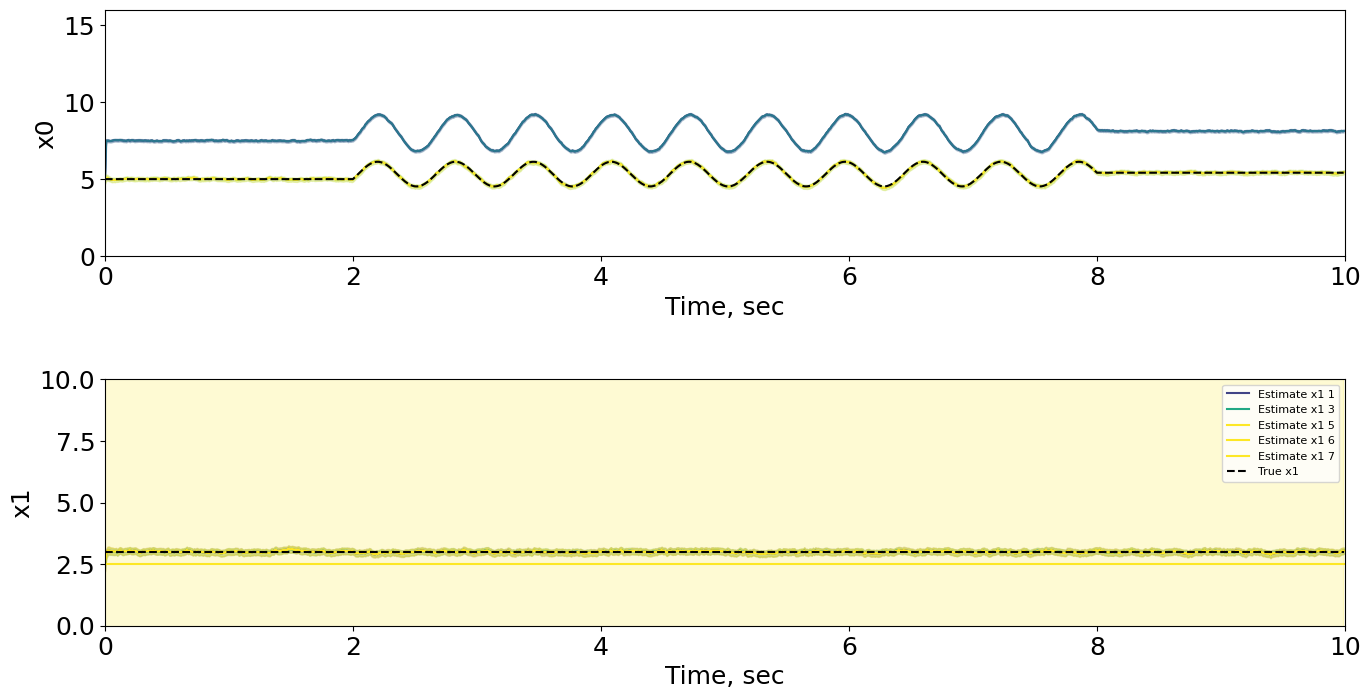

In [ ]:
# plot only trustworthy windows
fig, axs = plt.subplots(2, 1, figsize=(16, 8))
fig.subplots_adjust(hspace=0.5)
# define a color map for the lines
cmap = plt.get_cmap('viridis', len(largest_clique_x0)+1)
for i in range(len(largest_clique_x0)):
    if i in trustworthy_x0:
        axs[0].plot(tsim, results[largest_clique_x0[i]]['x0_hat'], label=f'Estimate x0 {i+1}', color=cmap(i+1))
        axs[0].fill_between(tsim, np.array(results[largest_clique_x0[i]]['x0_hat']) - np.array(three_sigma_x0[largest_clique_x0[i]]), 
                            np.array(results[largest_clique_x0[i]]['x0_hat']) + np.array(three_sigma_x0[largest_clique_x0[i]]), 
                            alpha=0.2, color=cmap(i+1))
axs[0].set_xlabel('Time, sec')
axs[0].set_ylabel('x0')
axs[0].set_ylim([0, 16])
axs[0].set_xlim([0, 10])
# Plot x0 on the first subplot as a dashed line onm top of all other lines
axs[0].plot(tsim, X[0, :], label='True x0', linestyle='--', color='black')
# legend
axs[1].legend(loc='upper right', fontsize=8)
for i in range(len(largest_clique_x1)):
    if i in trustworthy_x1:
        axs[1].plot(tsim, results[largest_clique_x1[i]]['x1_hat'], label=f'Estimate x1 {i+1}', color=cmap(i+1))
        axs[1].fill_between(tsim, np.array(results[largest_clique_x1[i]]['x1_hat']) - np.array(three_sigma_x1[largest_clique_x1[i]]), 
                            np.array(results[largest_clique_x1[i]]['x1_hat']) + np.array(three_sigma_x1[largest_clique_x1[i]]), 
                            alpha=0.2, color=cmap(i+1))
axs[1].set_xlabel('Time, sec')
axs[1].set_ylabel('x1')
axs[1].set_ylim([0, 10])
axs[1].set_xlim([0, 10])
# Plot x1 on the second subplot
axs[1].plot(tsim, X[1, :], label='True x1', linestyle='--', color='black')
# legend
axs[1].legend(loc='upper right', fontsize=8)

plt.show()